# 10 Spatial Reference Projection

- Alma Andersson
- Paulo Czarnewski

- Spatial Omics Data Analysis 2022

In this tutorial, we will be using Eggplant (Andersson et al 2022) to transfer information from different spatial-omics sections to a single reference (common coordinate framework).

Please make sure you have these software versions:
```
numpy            == 1.22.0
torch            == 1.8.1
gpytorch         == 1.4.1
spatial-eggplant == 0.2.3
```


In [37]:
!pip show spatial-eggplant numpy torch gpytorch

Name: spatial-eggplant
Version: 0.2.3
Summary: Landmark-based transfer of spatial transcriptomics data
Home-page: https://github.com/almaan/eggplant
Author: Alma Andersson
Author-email: almaan@kth.se
License: 
Location: /Users/paulo.czarnewski/miniconda3/envs/spatial2022/lib/python3.9/site-packages
Requires: anndata, gpytorch, kneed, matplotlib, morphops, numba, numpy, pandas, scanpy, scipy, squidpy, torch, tqdm
Required-by: 
---
Name: numpy
Version: 1.22.0
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD
Location: /Users/paulo.czarnewski/miniconda3/envs/spatial2022/lib/python3.9/site-packages
Requires: 
Required-by: anndata, bokeh, cellpose, dask-image, fastremap, geosketch, gsea-api, gseapy, h5py, hyperopt, imagecodecs, imageio, kneed, matplotlib, matplotlib-venn, mnnpy, morphops, MulticoreTSNE, napari, napari-svg, numba, numcodecs, opencv-python, opencv-python-hea

If not, please install these packages with the line below and SHUTDOWN this notebook (so the instalations take effect).

In [38]:
#!pip install numpy==1.22.0 torch==1.8.1 gpytorch==1.4.1



## How does the method work? (brief)

The method is more thoroughly described in it’s associated [manuscript](https://www.biorxiv.org/content/10.1101/2021.11.11.468178v1?rss=1), but to briefly outline the five main steps, we will use the same flowchart as is presented in Figure 1A (of the above referenced manuscript).



![img](https://camo.githubusercontent.com/f5f2872e866ab6c334181d05601ef4a20ca3b231aac8358fd90e5f6c7cfda0ee/68747470733a2f2f7370617469616c2d656767706c616e742e72656164746865646f63732e696f2f656e2f6c61746573742f5f696d616765732f666c6f772e706e67)

1. Construct/choose a reference that you want to transfer information to, choose samples to transfer information from.
2. Chart the landmarks, i.e., annotate common landmarks in both the reference and observed data.
3. Select feature of interest, e.g., expression of your favorite gene
4. Learn a transfer function relating landmark distances to expression
5. Transfer information to the reference, apply the transfer function to each location in the reference

To elaborate a bit more on the flow of information from observed data to the reference we refer to the image below.

![img2](https://camo.githubusercontent.com/c249779610f5d08c253a73a3cb982a599a678536691dccc8a50fe624b84d05c4/68747470733a2f2f7370617469616c2d656767706c616e742e72656164746865646f63732e696f2f656e2f6c61746573742f5f696d616765732f66756c6c666c6f772e706e67)

We start by creating a distance matrix $X$ for the observed data, containing the distance from every observation to each landmark. Next, we also create the feature vector containing the values for our feature of interest at each location. We model $y$ as a function ($f$) of $X$ and assume that this function is distributed according to a Gaussian Process, and may thus fit it accordingly (using Gaussian Process Regression).

To transfer the information, we first create a similar distance matrix to $X$ but for all of the locations in our reference, this is denoted $\bar{X}$. Finally, we apply the (learnt) function $f$ to $\bar{X}$, rendering a new feature vector which represents an estimate of the feature values at each of the reference locations.


## Load libraries 

Let's start by loading the libraries to be used. If you had problems to install eggplant, you can do so by pip and make sure that you are using NumPy version 1.21 or above.

```
%%bash
pip install spatial-eggplant
```

In [1]:
from urllib import request
from tqdm import tqdm

In [2]:
request.urlretrieve(
    'https://raw.githubusercontent.com/almaan/eggplant/master/landmark-selection/chart.py' ,
    './chart.py' )

('./chart.py', <http.client.HTTPMessage at 0x10e1b97c0>)

In [3]:
# Basic system functionalities
import matplotlib.pyplot as plt
import os.path as osp
from os import listdir, makedirs, unlink
import pickle

# Data science tools
import pandas as pd
from PIL import Image

# Single cell and spatial omics tools
import anndata as ad
import scanpy as sc
import squidpy as sq

# Eggplant tools
import eggplant as eg
import chart as ct

## Load Visium dataset

With libraries loaded, we can now load our Visium datasets.

In [4]:
adata = sc.read_h5ad('../results/spatial_transcriptomics/spatial_transcriptomics_qc_int_dr_cl.h5ad')
adata.obs_names_make_unique()

/Users/paulo.czarnewski/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Since we want to project many samples to the same reference, it is easier to work with a dictionary of datasets, so each dataset is a named entry. In other words, we just need to split the full dataset per sample.

In [5]:
adata_dict = {}

for batch in adata.obs['sample_id'].unique():
    adata_dict[ batch ] = adata[adata.obs['sample_id'].isin([batch])]
    spat = adata.uns['spatial']
    adata_dict[ batch ].uns['spatial'] =  {key: spat[key] for key in [batch]}

/Users/paulo.czarnewski/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/Users/paulo.czarnewski/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [8]:
adata_dict['154441'].write_h5ad("../results/spatial_transcriptomics/154441.h5ad")
adata_dict['154442'].write_h5ad("../results/spatial_transcriptomics/154442.h5ad")

## Landmark Annotation

The next step is to define the tissue landmarks present in both tissues. We can do this by downloading a helper function from eggplant and running it on the images from our samples. You can take a look at the images on your computer and realise that there are many areas that common between the tissues. You can therefore annotate them with the same landmark number. The function will directly save the landmarks (as Pandas DataFrame) inside the AnnData object in the `uns["curated_landmarks"]` field.

Please use this image as an example for annotate landmarks:

![landmarks](./landmarks.svg)

In [9]:
!python ./chart.py ../results/spatial_transcriptomics/154441.h5ad

/Users/paulo.czarnewski/repos/workshop-spatial/labs/./chart.py:5: DeprecationWarning: Support for PyQt5 is deprecated and will be removed in Pillow 10 (2023-07-01). Use PyQt6 or PySide6 instead.
  from PIL.ImageQt import ImageQt
/Users/paulo.czarnewski/repos/workshop-spatial/labs/./chart.py:41: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_image = image.resize((int(im_w * sf), int(im_h * sf)), Image.ANTIALIAS)
/Users/paulo.czarnewski/repos/workshop-spatial/labs/./chart.py:154: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  undo_button.setGeometry(
/Users/paulo.czarnewski/repos/workshop-spatial/labs/./chart.py:164: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version o

In [10]:
!python ./chart.py ../results/spatial_transcriptomics/154442.h5ad

/Users/paulo.czarnewski/repos/workshop-spatial/labs/./chart.py:5: DeprecationWarning: Support for PyQt5 is deprecated and will be removed in Pillow 10 (2023-07-01). Use PyQt6 or PySide6 instead.
  from PIL.ImageQt import ImageQt
/Users/paulo.czarnewski/repos/workshop-spatial/labs/./chart.py:41: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_image = image.resize((int(im_w * sf), int(im_h * sf)), Image.ANTIALIAS)
/Users/paulo.czarnewski/repos/workshop-spatial/labs/./chart.py:154: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  undo_button.setGeometry(
/Users/paulo.czarnewski/repos/workshop-spatial/labs/./chart.py:164: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version o

After running the sample annotation above, you should have those folders with the landmarks annotated in your computer. If not, you can also download our pre-annotated files from:

## Visualise landmarks on the AnnData object

With landmarks in hand, we can now add them to our AnnData objects, repectivelly.

In [6]:
adata_dict['154441'] = ad.read_h5ad('../results/spatial_transcriptomics/154441.h5ad')
adata_dict['154442'] = ad.read_h5ad('../results/spatial_transcriptomics/154442.h5ad')

We can inspect the data set by using one of eggplant's plot functions `visualize_observed` from the `methods (fun)` module. We're not interested in any special feature (at this moment) so we set `features=None`. However, we want to see what the sample tissue looks like, and since this is Visium data we have an HE-image; to show the image we set `show_image = True`. The parameter `n_cols` determines the number of columns in the generated plot.

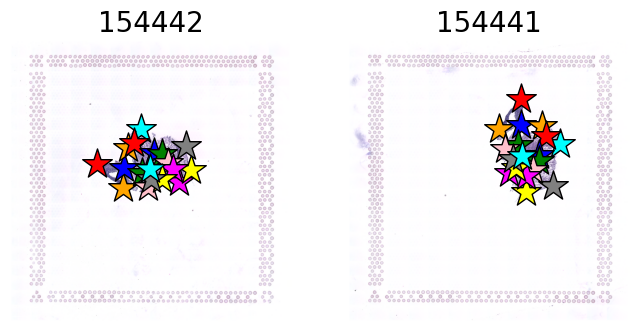

In [7]:
eg.plot.visualize_observed(
    adatas = adata_dict,
    features = None,
    marker_size = 2,
    show_image =True,
    n_cols = len(adata_dict))

## Creating a reference

With the samples annotated, we can now either:
- choose one sample to be the reference, or
- draw/choose any other image as reference (as long as it makes sense)

Here, we will project both samples to sample `154441`. Having established that our reference image and landmarks look good, we'll now convert the reference image into a spatial domain (defined by a set of grid points) that can be used to assemble the reference object. The reference_to_grid function is used for this. Said function takes four arguments:

- `ref_img` : the first argument, constituting the reference image
- `n_approx_points` : approximately how many points that the - to be generated - grid should contain. You can set this as high as you want, but it's reasonable to put it in the same order of magnitude or slightly higher than the number of observations in the spatial data.
- `n_regions` : if you've annotated your reference, indicate how many regions (encoded by different colors) there are.
- `background_color` - what backround color you reference image has. Transparent images will not work.

Since we will use the raw H&E image, we can set `n_regions=1`.

We can extract the image and scalefactors with:

In [8]:
image, scalefactor = ct.get_image_from_anndata(adata_dict['154441'])

And then we can just double-check if the landmarks are correct 

In [9]:
ref_img, scalefactor = ct.get_image_from_anndata(adata_dict['154441'])
ref_lmk = adata_dict['154441'].uns['curated_landmarks'] / scalefactor

dh_grid_crd,dh_mta = eg.pp.reference_to_grid(
    ref_img = ref_img,
    n_approx_points = 10000,
    n_regions = 4,
    background_color = "white" )

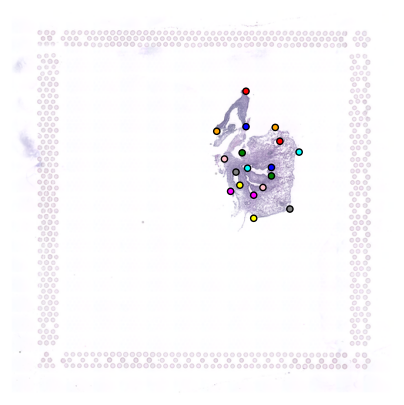

In [10]:
plt.figure(figsize = (5,5))
lmk_cmap = eg.constants.LANDMARK_CMAP
cmap = eg.pl.ColorMapper(lmk_cmap)

plt.imshow(ref_img,alpha = 0.7)
plt.scatter(
    x = ref_lmk[:,0],
    y = ref_lmk[:,1],
    marker = "o",
    edgecolor = "black",
    c = cmap(ref_lmk),
    s = 20)

plt.axis("off")
plt.show()

Create spatial grid and meta data. This time, no regions have been annotated, so we'll let n_regions=1.

In [11]:
grid_crd , mta = eg.pp.reference_to_grid(
    ref_img = ref_img,
    n_approx_points = 1000,
    n_regions = 1 )

Inspect the generated grid and how the landmarks relate to it.

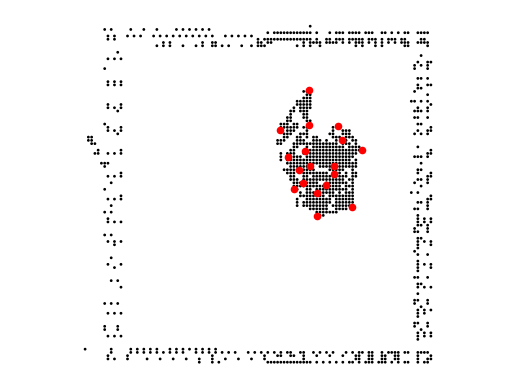

In [12]:
# plot the generated grid
plt.scatter(
    x = grid_crd[:,0],
    y = grid_crd[:,1],
    c = mta,
    cmap = plt.cm.binary_r,
    s = 1 )

# plot the landmarks
plt.scatter(
    x = ref_lmk[:,0],
    y = ref_lmk[:,1],
    marker = "o",
    c = "red",
    s = 20 )

# plot aesthetics
plt.gca().invert_yaxis()
plt.axis("equal")
plt.axis("off")
plt.show()

We can see that the fiducials (the dotted spots in the outer perimeter) of the image are also defined as "sample", but we can easily remove them by selecting points outside the landmark range.

In [13]:
sel = grid_crd[:,0] > ref_lmk[:,0].min()
sel = sel & (grid_crd[:,0] < ref_lmk[:,0].max() )
sel = sel & (grid_crd[:,1] > ref_lmk[:,1].min() )
sel = sel & (grid_crd[:,1] < ref_lmk[:,1].max() )

grid_crd_filt  = grid_crd[ sel , :]
mta_filt = mta[ sel ]

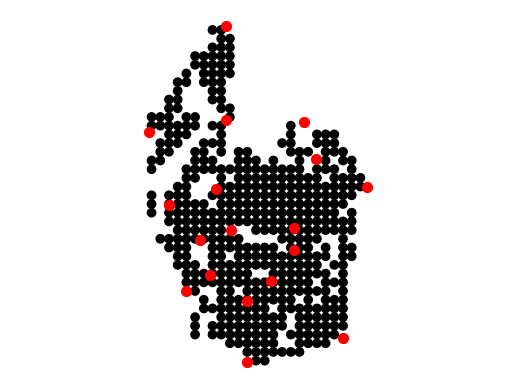

In [14]:
plt.scatter(
    x = grid_crd_filt[:,0],
    y = grid_crd_filt[:,1],
    c = mta_filt,
    cmap = plt.cm.binary_r )

plt.scatter(
    x = ref_lmk[:,0],
    y = ref_lmk[:,1],
    marker = "o",
    c = "red",
    s = 50 )

plt.gca().invert_yaxis()
plt.axis("equal")
plt.axis("off")
plt.show()

From the grid and landmarks we may now create a `Reference` object, which will be used in the transfer process.

In [15]:
ref = eg.m.Reference(
    domain = grid_crd_filt,
    landmarks = ref_lmk,
    meta = dict(region = mta_filt) )

## Load and process Expression Data

Next, we execute some standard pre-processing steps such as filter, normalize, log-transform, and scaling. However, we also match the scales between the observed data and the reference (`match_scales`), after which we compute the distance for every spot to each landmark (`get_landmark_distance`). We supply the aforementioned function with the reference object, to conduct TPS warping and thus account for non-homogenous disruptions in the morphology.

In [16]:
for adata in adata_dict.values():
    
    eg.pp.default_normalization(
        adata = adata,
        min_cells = 0.1,
        total_counts = 1e4,
        exclude_highly_expressed=False)

    eg.pp.match_scales(adata , ref)
    
    eg.pp.get_landmark_distance(
        adata = adata,
        reference = ref )

    eg.pp.spatial_smoothing(adata)

As is proper, we then inspect our processed data to see that everything looks as expected.

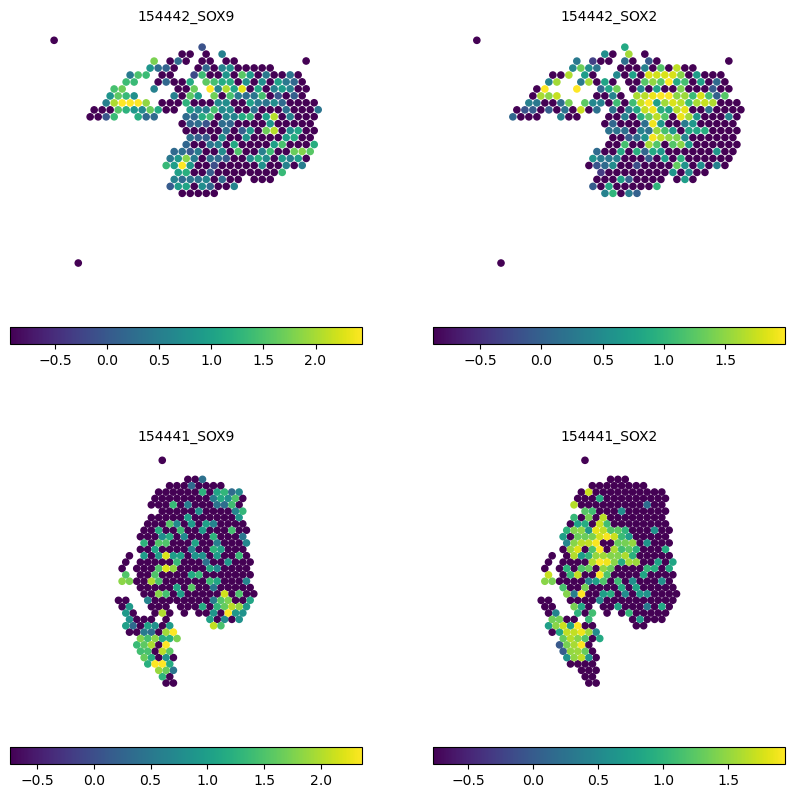

In [17]:
GENE_LIST = ["SOX9","SOX2"]

eg.pl.visualize_observed(
    adatas = adata_dict,
    features = GENE_LIST,
    n_rows = 2,
    include_title = True,
    fontsize = 10,
    marker_size = 20,
    share_colorscale = False,
    separate_colorbar = False,
    colorbar_fontsize = 10,
    side_size = 5,
    show_landmarks = False,
    quantile_scaling = True )


We now transfer our data to the reference using the `transfer_to_reference` function. Here we use the gene Nrgn as our target of interest, but this may be exchanged for any of the other two genes presented in the supplementary (or any gene of the users liking). We use 
1000 epochs and cuda acceleration, if possible. We also set `verbose=True` in order to be able to follow the progress.

In [21]:
losses = eg.fun.transfer_to_reference(
    adatas = adata_dict,
    reference = ref,
    layer = "smoothed",
    features = GENE_LIST,
    n_epochs = 500,
    device = "cpu",
    verbose = True , )

[Processing] ::  Model : 154442 | Feature : SOX9 | Transfer : 1/4


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 110.57it/s]


[Processing] ::  Model : 154442 | Feature : SOX2 | Transfer : 2/4


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 116.78it/s]


[Processing] ::  Model : 154441 | Feature : SOX9 | Transfer : 3/4


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 101.76it/s]


[Processing] ::  Model : 154441 | Feature : SOX2 | Transfer : 4/4


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 105.95it/s]


You don't really have to pay attention to the next cell, just execute it. If you run this notebook in demo mode, it will load the pre-analyzed data. If you're not running in demo mode, and you've set the `SAVE_OBJS` variable to True it will save your results.

In [22]:
OBJ_DIR = "../results/spatial_transcriptomics"

pickle.dump(losses,open(osp.join(OBJ_DIR,"losses.p"),"wb"))
ref.adata.write_h5ad(osp.join(OBJ_DIR,"reference.h5ad"))

We can assess the losses of each model, to make sure they converged.

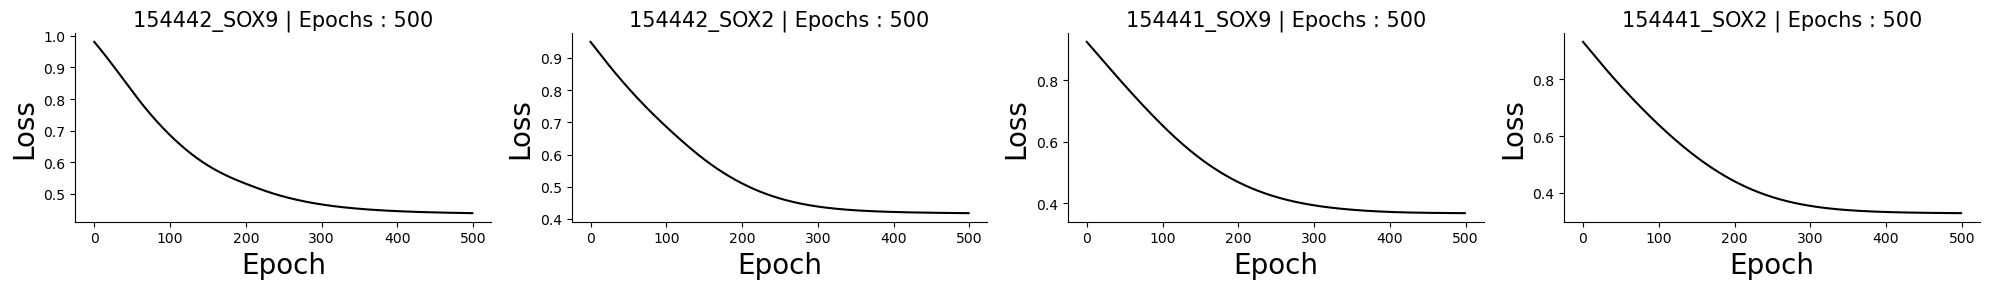

In [23]:
eg.pl.model_diagnostics(losses = losses)

Given that the losses looks ok, we should have some good results! We'll inspect the transfer using the visualize_transfer function.

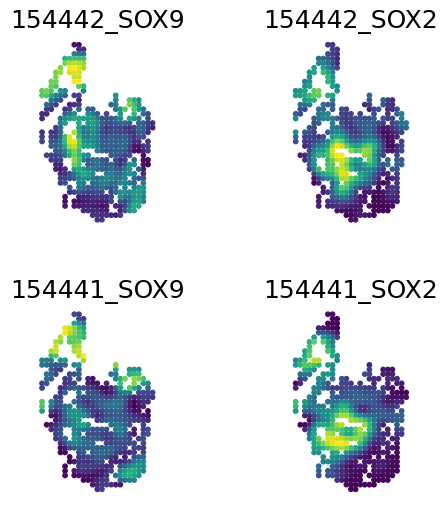

In [24]:
fig,ax = eg.pl.visualize_transfer(
    reference = ref ,
    n_cols = len(GENE_LIST),
    side_size = 3,
    quantile_scaling = False,
    flip_y = True,
    show_landmarks = False,
    marker_size = 10,
    include_colorbar = False,
    separate_colorbar = False,
    share_colorscale = False,
    fontsize = 18,
    colorbar_fontsize = 10,
    hspace = 0.4,
    return_figures = True )

What we've done so far is very similar to the developmental heart analysis, but what the next step intorduces a new element: a comparison of the spatial feature expression between the different conditions. This is what we refer to as **spatial differential expression analysis** or `SDEA `for short (which builds on the concept of spatial arithmetics).

You can specify which feature you want to assess by setting the variable compare_feature = `feature_of_interest`. To execute the analysis, we then use the sdea function from the sdea module of eggplant.

We subset the transferred information (found in mp_ref.adata) to only include the transferred information corresponding to our feature of interest. With `group_col="model"` we indicate that features expression should be compared across the different models (conditions). Finally, with `n_std` we state that for expression in a point to be considered differentially expressed between two conditions, the feature expression envelopes of  for each condition must not overlap. For a more detailed explanation of the sdea, I would refer to the preprint.

In [25]:
compare_feature = "SOX9"
sdea_res = eg.sdea.sdea(
    data = ref.adata[:,ref.adata.var.feature.values == compare_feature],
    group_col="model",
    n_std=2 )

We can visualize our SDEA results by using the function visualize_sdea_results.

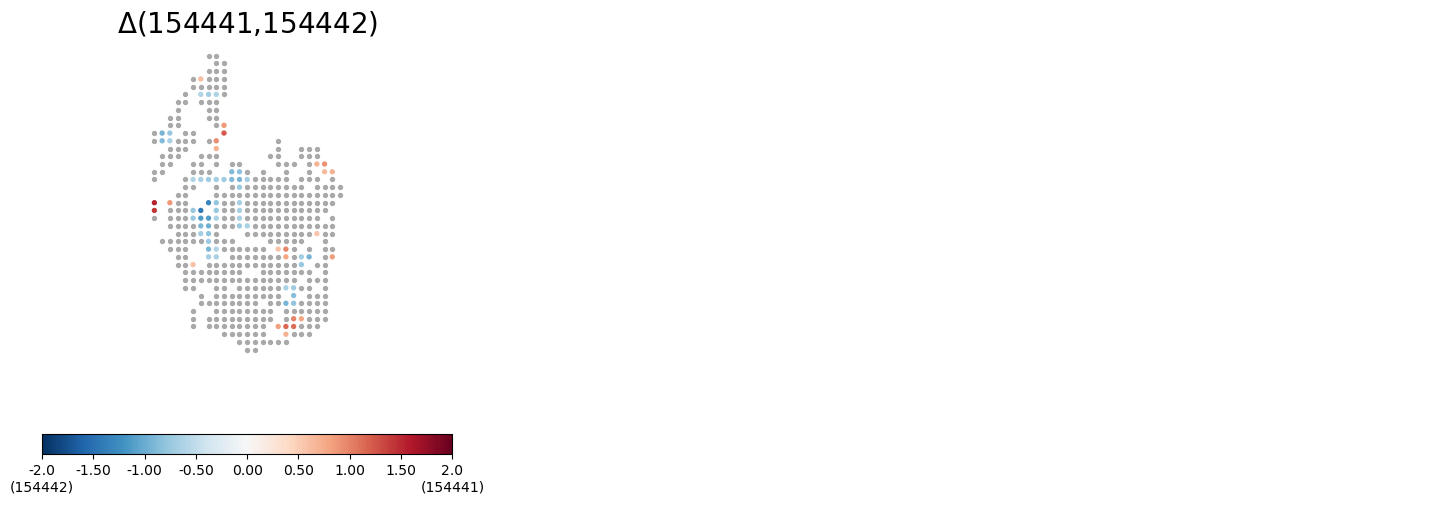

In [26]:
eg.pl.visualize_sdea_results(
    ref,
    sdea_res,
    n_cols = 3,
    marker_size = 8,
    side_size = 6,
    colorbar_orientation ="horizontal",
    title_fontsize = 20,
    colorbar_fontsize = 10,
    no_sig_color = "darkgray" )

This highlights the differences between samples.

You can, of course, you devote more time to this kind of analysis - so feel free to explore it on your own. However, as final part of this tutorial, we'll have a look at something we've chosen to call **fast approximate transfer**.

## Fast approximate transfer

So far, we've transferred a select set of genes, where each transfer has been relatively fast - but if it was to be repeated for every gene, a time of 30s is way too much. To address this issue, there's an alternative transfer function that can be used. The transfer it implements scales extremely well w.r.t. the number of genes, actually it's O(1). This transfer is __"fast approximate transfer"__. However, this nice scaling property comes at the cost of exactness, and the result will only be an approximation of the true spatial distribution in the reference.

For the interested:
The fast approximate transfer first projects the feature values from the high-dimensional (e.g., ~20'000 dimensions if gene expression) into a low K-dimensional space, essentially compressing the data. Next, contributions from each component building up the low-dimensional space is transferred to the reference. Finally, the complete full-dimensional data is reconstructed in the reference, once all the components have been transferred.

To explore the fast approximate transfer feature, we'll create a new reference object using the same input as for the exact transfer.

In [27]:
fa_ref = eg.m.Reference(
    domain = grid_crd_filt ,
    landmarks = ref_lmk,
    meta = dict(region = mta_filt ) )

In [28]:
mta_filt.shape

(469,)

In [29]:
ref_lmk.shape

(18, 2)

In [30]:
grid_crd_filt.shape

(469, 2)

To transfer data using the fast approximate strategy, we'll use the function `fa_transfer_to_reference`. Superficially, it works in the same way as the standard `transfer_to_reference` - only difference being that instead of specifying which features you want to transfer, you specify the number of components using the `n_components` argument.

The more components you use, the more accurate the transfer will be (though with diminishing effect). Unfortunately, the more components you use, the slower the transfer will be. In this analysis we'll use 10 components.

**NOTE:** As a proof of concept we'll only transfer information from the top _`100` highly variable genes_ to the reference, but you could just as well transfer data from all genes (but that will take a long time). In general, transfering the top 2000-4000 genes should be enough, but make sure your genes of interest are present in the gene list.

In [31]:
# Compute HVG (highly variable genes)
hvg_table = sc.pp.highly_variable_genes(
    adata = adata, 
    n_top_genes = 100,
    inplace = False, 
    batch_key = "sample_id")

/Users/paulo.czarnewski/miniconda3/envs/spatial2022/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


In [67]:
# Get the highly variable genes (HVGs)
HVGS = hvg_table.index[ hvg_table['highly_variable'] ]

In [69]:
# Filter our dictionary to only contain those genes
adata_dict_100GENES = {}
for k in list(adata_dict.keys()):
    adata_dict_100GENES[k] = adata_dict[k][:,HVGS]

We can now run Fast Approximate Transfer on the subseted AnnData dictionary

In [70]:
list(adata_dict_100GENES.keys())

['154442', '154441']

In [71]:
fa_losses = eg.fun.fa_transfer_to_reference(
    adatas = adata_dict_100GENES,
    reference = fa_ref,
    n_components = 10,
    n_epochs = 1000,
    verbose = True )

0it [00:00, ?it/s]

[Processing] ::  Model : 0 | Transfer : 1/2


/Users/paulo.czarnewski/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
1it [01:28, 88.56s/it]

[Processing] ::  Model : 1 | Transfer : 2/2


/Users/paulo.czarnewski/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
2it [03:04, 92.34s/it]


KeyError: '154442'

Again, the cell below simply loads/saves data depending on your notebook settings.

In [72]:
fa_ref.adata.var.model

154442_0_0    154442
154442_0_1    154442
154442_0_2    154442
154442_0_3    154442
154442_0_4    154442
154442_0_5    154442
154442_0_6    154442
154442_0_7    154442
154442_0_8    154442
154442_0_9    154442
154441_1_0    154441
154441_1_1    154441
154441_1_2    154441
154441_1_3    154441
154441_1_4    154441
154441_1_5    154441
154441_1_6    154441
154441_1_7    154441
154441_1_8    154441
154441_1_9    154441
Name: model, dtype: object

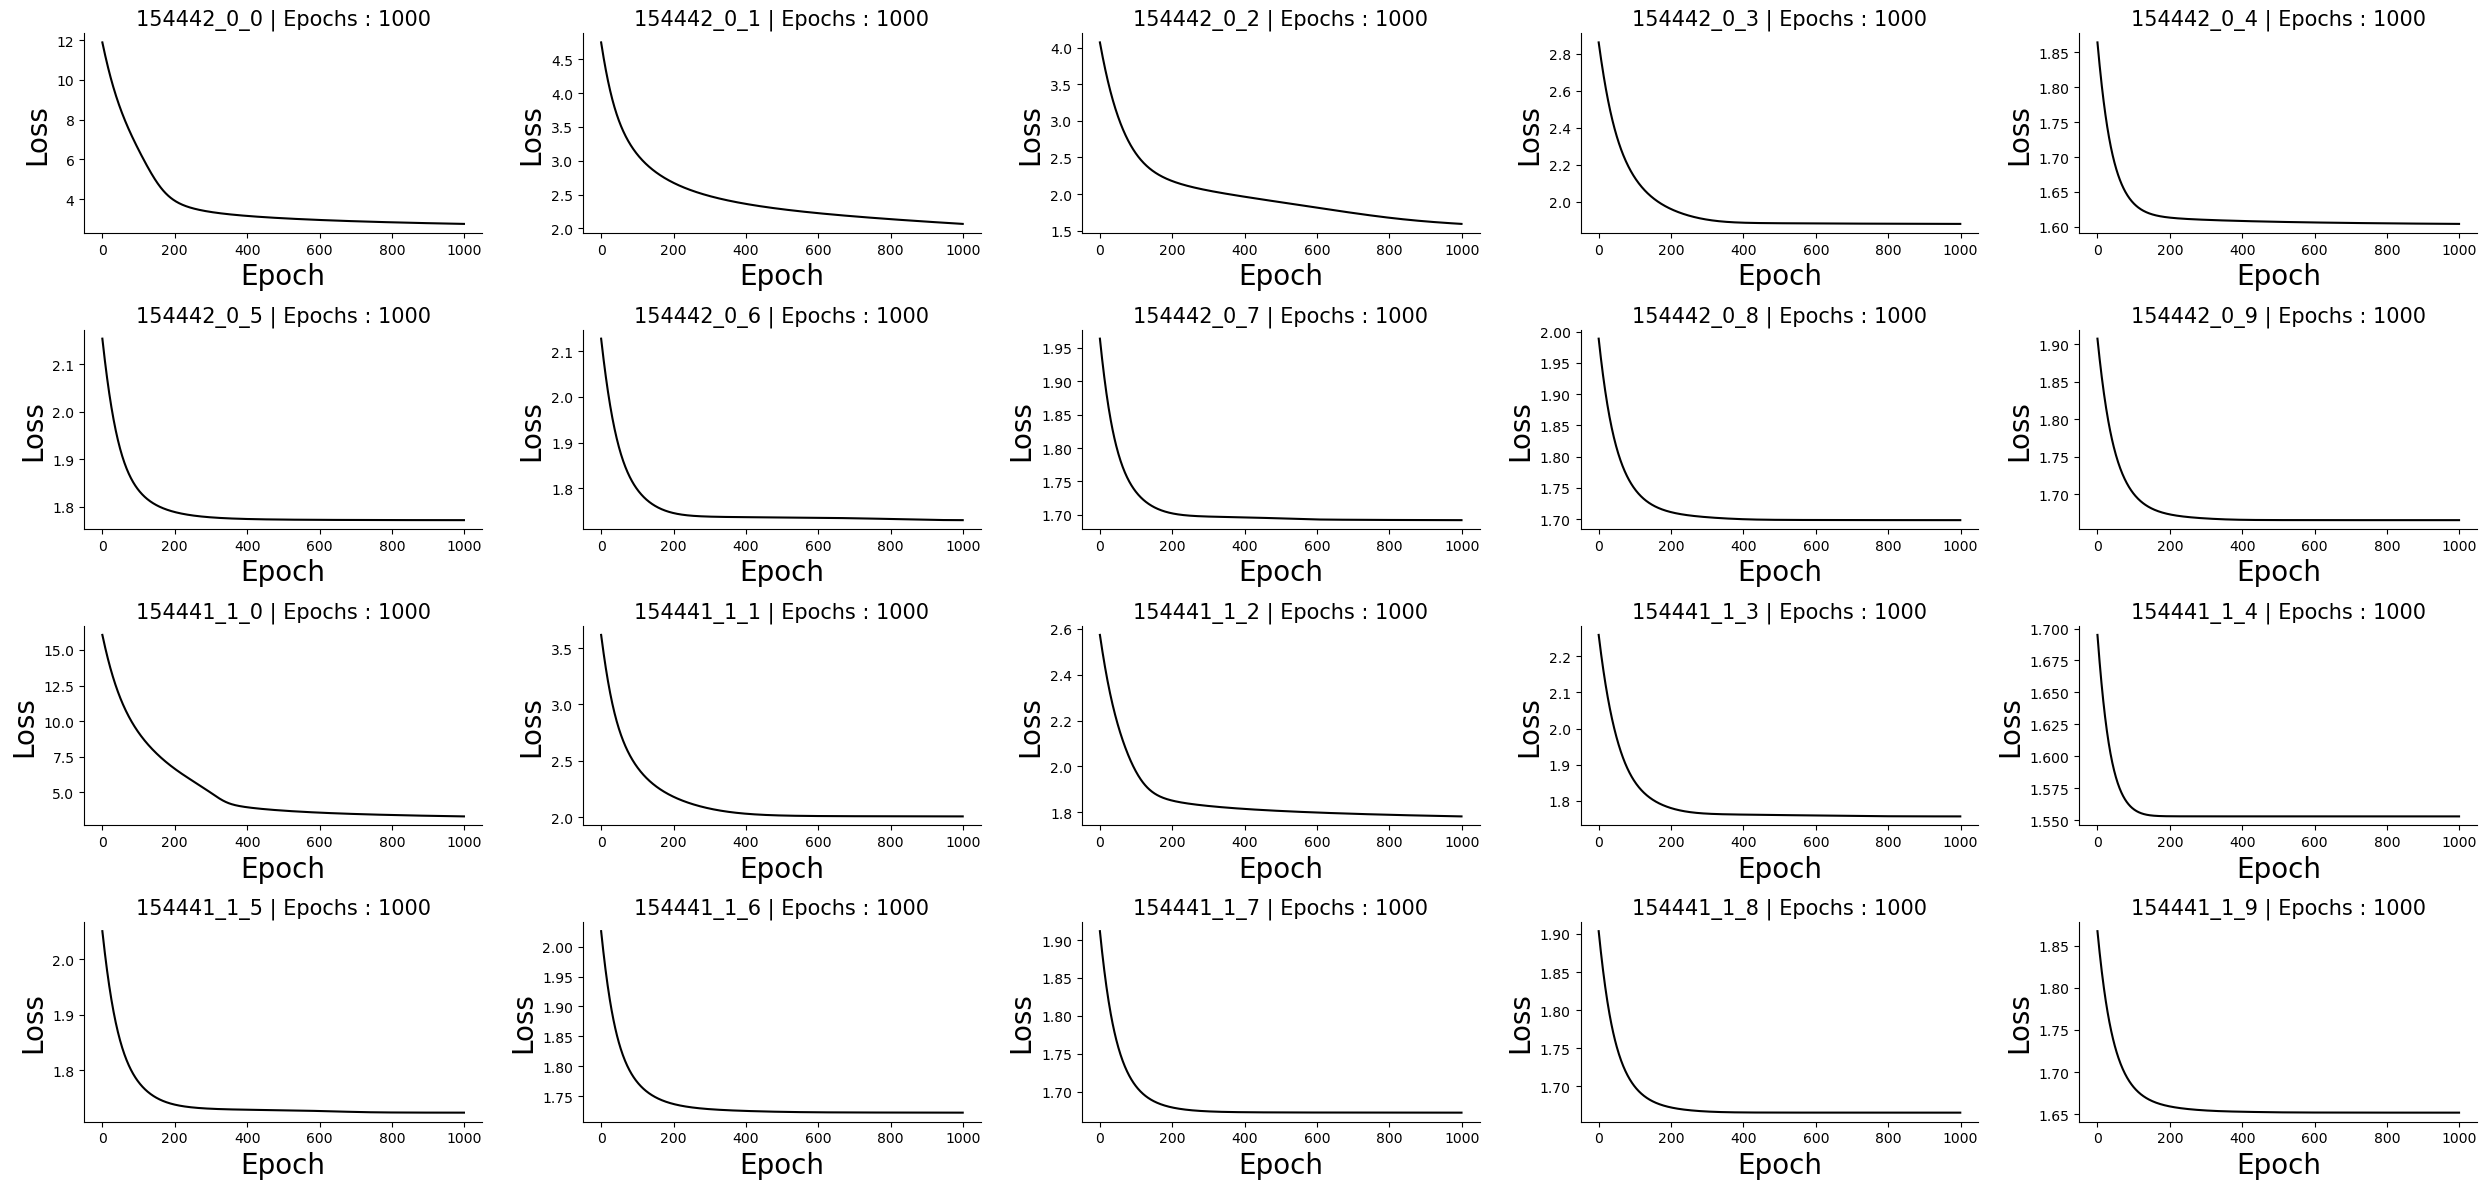

In [40]:
eg.pl.model_diagnostics(losses = fa_losses)

Now, since we've transferred the whole transcriptome - we can plot any feature of our choice. As an example, we'll visualize six arbitrarily chosen genes in the reference.

In [ ]:
GENE_LIST = ["SOX9","SOX2"]

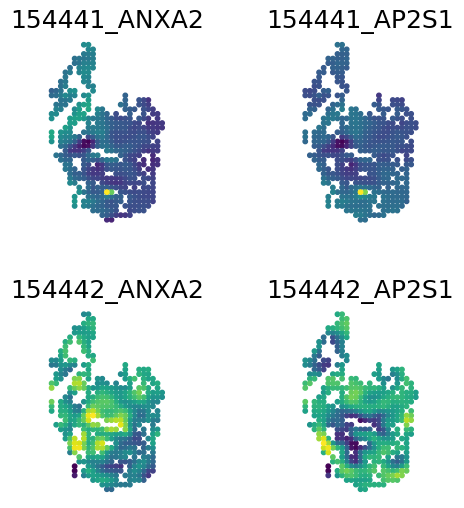

In [47]:
fig,ax = eg.pl.visualize_transfer(
    reference = fa_ref ,
    attributes = FA_GENES,
    n_cols = len(FA_GENES),
    side_size = 3,
    quantile_scaling = False,
    flip_y = True,
    show_landmarks = False,
    marker_size = 10,
    include_colorbar = False,
    separate_colorbar = False,
    share_colorscale = False,
    fontsize = 18,
    colorbar_fontsize = 10,
    hspace = 0.4,
    return_figures = True )

In [ ]:
eg.pl.visualize_observed(
    adatas = adata_dict,
    features = GENE_LIST,
    n_rows = 2,
    include_title = True,
    fontsize = 10,
    marker_size = 20,
    share_colorscale = False,
    separate_colorbar = False,
    colorbar_fontsize = 10,
    side_size = 5,
    show_landmarks = False,
    quantile_scaling = True )

And that's about it, this is a very brief introduction to eggplant. For any questions feel free to contact me at: alma.andersson@differentiable.net or, preferably, open an issue on github.